In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

## Downloading data

In [2]:
!pip install -q kaggle

In [3]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/datasets/kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

100% 309M/309M [00:03<00:00, 101MB/s] 
100% 309M/309M [00:03<00:00, 94.0MB/s]


In [5]:
# Kaggle Human Emotion Dataset: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
# task: image multiclass classification

!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [6]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry","happy","sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 5,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred', # the makes the labels match the subdirectories
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
    #validation_split=0.2,
    #subset="training", #or validation
)

Found 6799 files belonging to 3 classes.


In [67]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred', # the makes the labels match the subdirectories
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
    #validation_split=0.2,
    #subset="training", #or validation
)

Found 2278 files belonging to 3 classes.


In [9]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

## data visualization and preparation

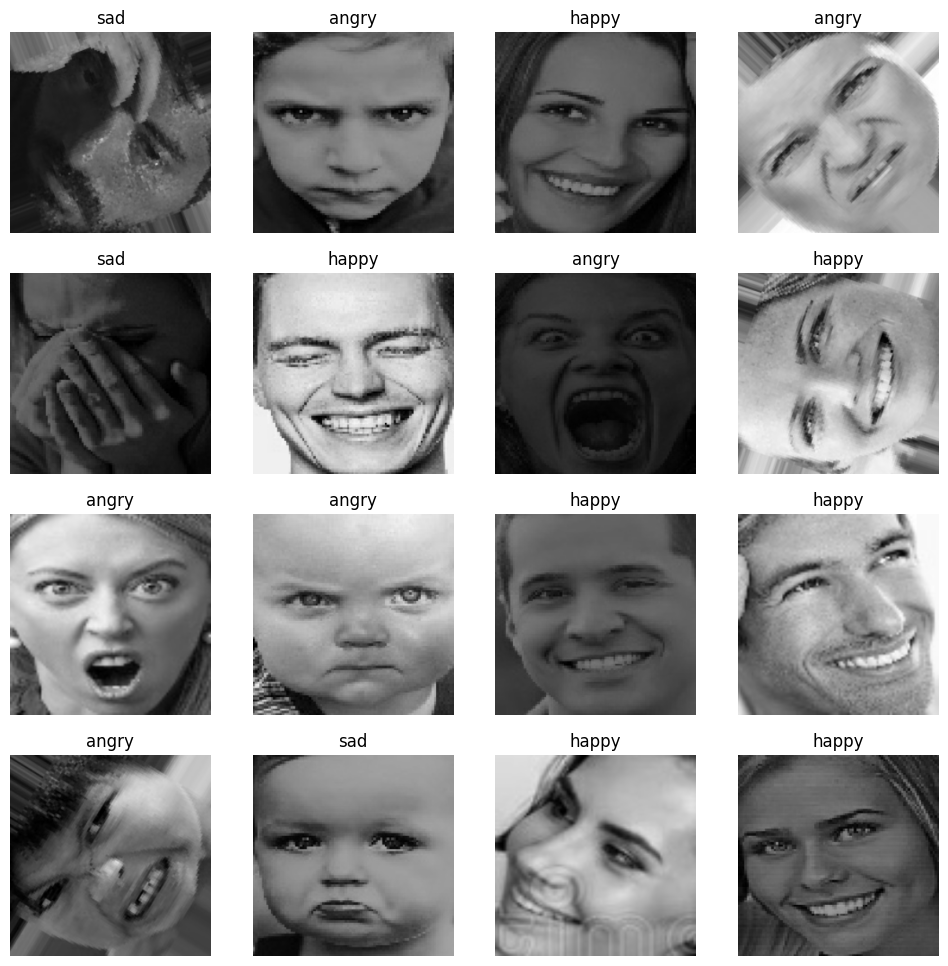

In [10]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.0)
    plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis("off")

## Data augmentation

In [11]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)), # need to tweak: the actual degree is 0.25x360=90 deg
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [12]:
# prefetch to make the processing faster

training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [13]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [14]:
# create resizing and rescaling layers; its part of the model

resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255)
])

## Models

### model1: LeNet

In [15]:
# Model1: LeNet

# similar to the LeNet design
# https://en.wikipedia.org/wiki/Convolutional_neural_network#/media/File:Comparison_image_neural_networks.svg

tf.keras.backend.clear_session()

lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),#none means any dim

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),#softmax for multiclass - [0.2,0.7,0.1] > [0,1,0]

])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      8

### model2: ResNet34

In [51]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training) # specify training pram; training=True: The layer will normalize its inputs using the mean and variance of the current batch of inputs.


    return x

In [52]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")#same: height and weight are not changed
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides) #1x1 conv layer so the dim can match

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training) # the 1x1 kernel layer is added to the input itself
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

In [53]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)#2 here is downsampling
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [54]:
# show summary
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False) #use a toy input to build a model
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

### model3: EfficientNet: fine-tuning (including training code)
Basic idea: use a pre-trained embedding on a small user-specific database \
new data > feature extractor > classifier > reuse the new model \
- You need very small LR

In [55]:
pre_trained1 = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)
    )

71686520/71686520 [==============================] - 0s 0us/step


#### guideline of fine-tuning

**Two very important variables: trainable(True) and training(False)** \
- trainable makes the pre-trained membedding changeable
- training makes dynamic computation of batch norms \

Steps:
- 1.model.trainable = False for transfer learning
- 2.change trainable to True
- 3.compile the model so the embedding gets update
- 4.set LR = LR/100 before training on the small dataset
- 5.if validation accuracy is higher, it means the fine-tuning is effective

In [ ]:
# freeze the embedding
pre_trained1.trainable = True

In [61]:
# functional API
input = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3))

x = pre_trained1(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretraining_model1 = Model(input, output)
pretraining_model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_41 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 128)               131200

In [ ]:
# training the model
checkpoint_callback = ModelCheckpoint(
    '/content/best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,#save best weights
    )

loss_function = CategoricalCrossentropy()

metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")] #topk allows k nearest labels


pretraining_model1.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

history1 = pretraining_model1.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = 1,#20
    verbose = 1,
    callbacks=[checkpoint_callback]
)

In [ ]:
pretraining_model1.evaluate(validation_dataset)

## Training

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,#save best weights
    )

In [16]:
loss_function = CategoricalCrossentropy()

In [17]:
"""# test the cce as a loss
y_true = [[0,1,0],[0,0,1]]
y_pred = [[0.01,0.05,0.96],[0.1,0.7,0.2]] #change classes
cce = tf.keras.losses.CategoricalCrossentropy()
print(cce(y_true,y_pred).numpy())"""

#SparseCategoricalCrosslentropy works for inputs like cls numbers such as [1,2,3]

'# test the cce as a loss\ny_true = [[0,1,0],[0,0,1]]\ny_pred = [[0.01,0.05,0.96],[0.1,0.7,0.2]] #change classes\ncce = tf.keras.losses.CategoricalCrossentropy()\nprint(cce(y_true,y_pred).numpy())'

In [18]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")] #topk allows k nearest labels

In [19]:
"""lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)"""

resnet_34.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]*10),#the paper says 0.1
  loss = loss_function,
  metrics = metrics,
)

In [20]:
"""history1 = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 20,
    verbose = 1
)"""

history1 = resnet_34.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 5,#60
    verbose = 1,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
213/213 [==============================] - 69s 256ms/step - loss: 0.9457 - accuracy: 0.5826 - top_k_accuracy: 0.8323 - val_loss: 1.1973 - val_accuracy: 0.3503 - val_top_k_accuracy: 0.7972
Epoch 2/20
213/213 [==============================] - 56s 260ms/step - loss: 0.7673 - accuracy: 0.6666 - top_k_accuracy: 0.8819 - val_loss: 0.9170 - val_accuracy: 0.5821 - val_top_k_accuracy: 0.8525
Epoch 3/20
213/213 [==============================] - 54s 254ms/step - loss: 0.6990 - accuracy: 0.7048 - top_k_accuracy: 0.8972 - val_loss: 0.7372 - val_accuracy: 0.6747 - val_top_k_accuracy: 0.9008
Epoch 4/20
213/213 [==============================] - 54s 253ms/step - loss: 0.6231 - accuracy: 0.7395 - top_k_accuracy: 0.9190 - val_loss: 0.7115 - val_accuracy: 0.7037 - val_top_k_accuracy: 0.9021
Epoch 5/20
213/213 [==============================] - 55s 255ms/step - loss: 0.6780 - accuracy: 0.7089 - top_k_accuracy: 0.9076 - val_loss: 1.0454 - val_accuracy: 0.5786 - val_top_k_accuracy: 0.8600
Epoch

## Loss plot

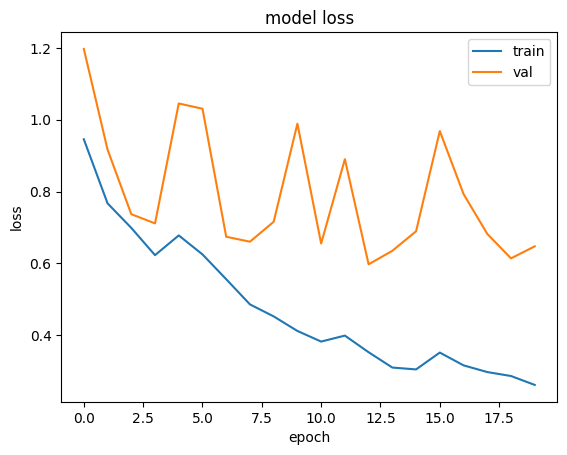

In [21]:
# plot loss history
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

## Evalution

In [22]:
#lenet_model.evaluate(validation_dataset)
resnet_34.evaluate(validation_dataset)
#load the best 34
#resnet_34.load_weights('best_weights')
#resnet_34.evaluate(validation_dataset)

72/72 [==============================] - 3s 37ms/step - loss: 0.6477 - accuracy: 0.7871 - top_k_accuracy: 0.9363


[0.6476597785949707, 0.7870939373970032, 0.9363476634025574]

## Prediction

From image to a readable tensor

In [23]:
# read an image with opencv
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109046.jpg_brightness_1.jpg")

# convert it to a tensor
im = tf.constant(test_image, dtype=tf.float32)

#add a batch dim before putting into a model
im = tf.expand_dims(im,axis=0)

print(lenet_model(im)) #happy
print(CLASS_NAMES[tf.argmax(lenet_model(im),axis=-1).numpy()[0]]) #happy

tf.Tensor([[4.0747233e-05 9.9850404e-01 1.4552621e-03]], shape=(1, 3), dtype=float32)
happy


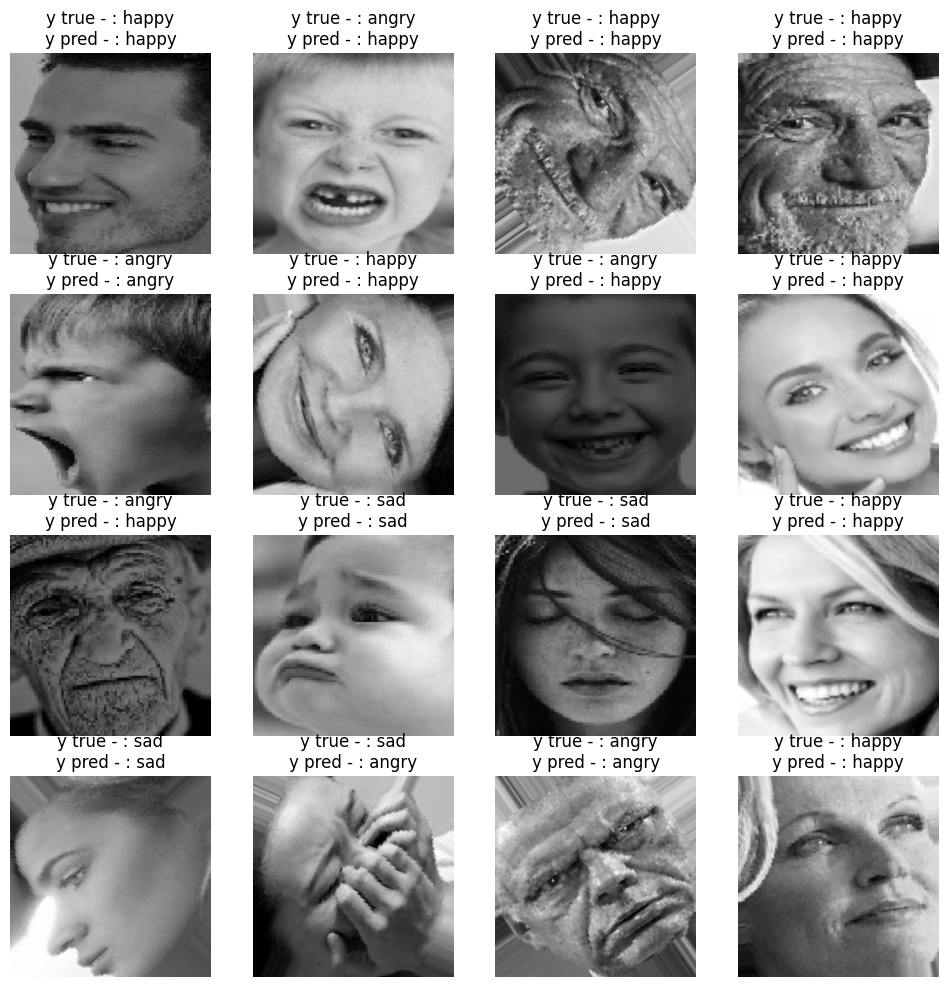

In [24]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.0)
    plt.title("y true - : "+CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()] + "\n" + "y pred - : "+ CONFIGURATION["CLASS_NAMES"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")

## Confusion matrix

In [25]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [26]:
# FLATTENING
# labels - need flatten them - argmax - the last axis(-1),
# labels[:-1] means avoiding the leftover non-batchsize split like 32,32,32,1

print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[1 1 0 ... 0 2 2]
[1 1 0 ... 0 2 2]


[[383  63  69]
 [ 41 882  83]
 [ 97 132 528]]


Text(0.5, 58.7222222222222, 'Predicted')

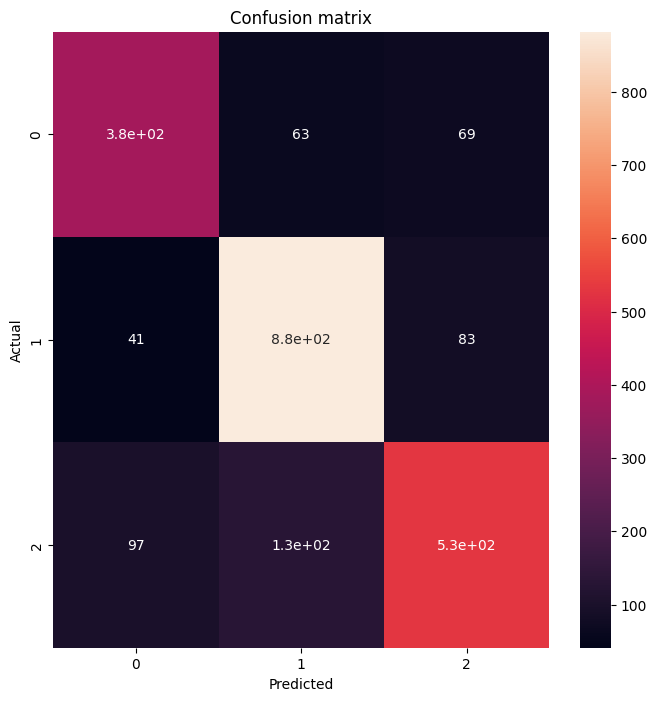

In [27]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Training with TF Records
advantages
- save the data training as embeddings for reuse (called Example class)
- usew shards for parallel training on several machines

In [36]:
# unbatch the data used before

"""train_dataset = (
    train_dataset
    .unbatch()
)

validation_dataset = (
    validation_dataset
    .unbatch()
)"""
train_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [42]:
# create a single tf Example

def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image])) # remember to add a list for input

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [43]:
!mkdir /content/tfrecords

In [44]:
# define shards

NUM_SHARDS = 10
PATH = '/content/tfrecords/shard_{:02d}.tfrecord' #filename.tfrecord

In [45]:
# need to encode the images as JPEG
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label) #directly conver 0,0,1 to 2(cls index)

encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [46]:
# Write the records to a file.
# https://www.tensorflow.org/api_docs/python/tf/io/TFRecordWriter
# save the shards in the hard drive


for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator() #make the dataset iterable
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

From shards back to batched tensors

In [47]:
# save shards

recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS)] )

In [48]:
# a function to return original data: images and labels

def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string), # a reversed create_example
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]


In [49]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [50]:
"""for i in parsed_dataset.take(1):
  print(i)"""

'for i in parsed_dataset.take(1):\n  print(i)'

The next step is to use the model just like before
Note: loss func should be SparseCrossentrophy because the cls now is individual integers like 0,1,2